In [35]:
import numpy as np
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import class_weight
import tensorflow as tf
import scipy.io
from livelossplot.tf_keras import PlotLossesCallback
import matplotlib.pyplot as plt

In [2]:
#Constantes
BATCH_SIZE = 16

# 1. Recolher dados

In [3]:
def get_upper_triang(arr):
    upper_triang = []
    for i in range(len(arr)):
        for j in range(len(arr)):
            if (j > i):
                upper_triang.append(arr[i][j])
                
    return np.array(upper_triang)

def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    print(train_mat.keys())
    print(test_mat.keys())
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    train_np_upper_triang = []
    for i in range(len(train_np)):
        train_np_upper_triang.append(get_upper_triang(train_np[i]))
    train_np_upper_triang = np.array(train_np_upper_triang)
    test_np_upper_triang = []
    for i in range(len(test_np)):
        test_np_upper_triang.append(get_upper_triang(test_np[i]))
    test_np_upper_triang = np.array(test_np_upper_triang)
    train_np = train_np_upper_triang
    test_np = test_np_upper_triang
    print('Train shape: ',train_np.shape)
    print('Test shape: ',test_np.shape)
    return  train_np, test_np

train_data, test_data = get_data_from_mat('train_data.mat','test_data.mat')

dict_keys(['__header__', '__version__', '__globals__', 'train_data'])
dict_keys(['__header__', '__version__', '__globals__', 'test_data'])
Train shape:  (112, 4005)
Test shape:  (28, 4005)


In [4]:
train_data[0]

array([0.        , 0.13152513, 0.        , ..., 0.        , 0.28060623,
       0.        ])

# 2. Preparar os datasets de treino e de teste

In [5]:
#Tornar cada matriz num vetor de uma dimensão (passar de 90x90 para 8100) e armazenar todos os valores de cada matriz
#O dicionário utilizado armazena, todos os valores com indíce X, pertencentes às diferentes 112 matrizes, sendo esse índice
#a chave do dic.
#Por exemplo: dictAttributes[0] contém o primeiro elemento de cada vetor anteriormente criado
dictAttributes = dict()
for i in range(len(train_data)):# len(train_data) - 112
    flatten_data = train_data[i].flatten()
    for j in range(len(flatten_data)):
        dictAttributes.setdefault(j,list())
        dictAttributes[j].append(flatten_data[j])

#Tornar cada matriz num vetor de uma dimensão (passar de 90x90 para 8100) e armazenar todos os valores de cada matriz
#O dicionário utilizado armazena, todos os valores com indíce X, pertencentes às diferentes 112 matrizes, sendo esse índice
#a chave do dic.
#Por exemplo: dictAttributes[0] contém o primeiro elemento de cada vetor anteriormente criado
dictAttributesTest = dict()
for i in range(len(test_data)):# len(test_data) - 28
    flatten_data = test_data[i].flatten()
    for j in range(len(flatten_data)):
        dictAttributesTest.setdefault(j,list())
        dictAttributesTest[j].append(flatten_data[j])
        
#Nesta fase criam-se colunas com todos os elementos que estão numa dada posição do vetor, a label da coluna é essa posição
scans_series = []
for k in dictAttributes.keys():
    scans_series.append(pd.Series(dictAttributes.get(k)))
    
#Nesta fase criam-se colunas com todos os elementos que estão numa dada posição do vetor, a label da coluna é essa posição
scans_series_test = []
for k in dictAttributesTest.keys():
    scans_series_test.append(pd.Series(dictAttributesTest.get(k)))

In [6]:
train_data_series = pd.concat(scans_series,axis=1)
train_data_series

,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0.0,0.131525,0.0,0.0,0.0,0.271538,0.0,0.0,0.0,0.374434,...,0.0,0.162305,0.0,0.585006,0.0,0.276153,0.0,0.0,0.280606,0.0
1,0.0,0.117704,0.0,0.0,0.0,0.316890,0.0,0.0,0.0,0.359445,...,0.0,0.171084,0.0,0.599437,0.0,0.320557,0.0,0.0,0.207478,0.0
2,0.0,0.155806,0.0,0.0,0.0,0.348072,0.0,0.0,0.0,0.335944,...,0.0,0.202426,0.0,0.630374,0.0,0.271738,0.0,0.0,0.246472,0.0
3,0.0,0.145214,0.0,0.0,0.0,0.310270,0.0,0.0,0.0,0.320711,...,0.0,0.178689,0.0,0.562505,0.0,0.390434,0.0,0.0,0.287888,0.0
4,0.0,0.161360,0.0,0.0,0.0,0.385560,0.0,0.0,0.0,0.284115,...,0.0,0.188561,0.0,0.564043,0.0,0.279060,0.0,0.0,0.234284,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.0,0.215767,0.0,0.0,0.0,0.390332,0.0,0.0,0.0,0.323281,...,0.0,0.243250,0.0,0.660292,0.0,0.349307,0.0,0.0,0.302675,0.0
108,0.0,0.143005,0.0,0.0,0.0,0.306380,0.0,0.0,0.0,0.364617,...,0.0,0.334296,0.0,0.630415,0.0,0.281757,0.0,0.0,0.204125,0.0
109,0.0,0.116085,0.0,0.0,0.0,0.290941,0.0,0.0,0.0,0.338786,...,0.0,0.210325,0.0,0.574355,0.0,0.444044,0.0,0.0,0.246784,0.0
110,0.0,0.156654,0.0,0.0,0.0,0.357540,0.0,0.0,0.0,0.365350,...,0.0,0.220760,0.0,0.631057,0.0,0.363958,0.0,0.0,0.216259,0.0


In [7]:
test_data_series = pd.concat(scans_series_test,axis=1)
test_data_series

,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0.0,0.140891,0.000000,0.0,0.0,0.332442,0.0,0.0,0.0,0.380829,...,0.0,0.276894,0.0,0.612109,0.0,0.251406,0.0,0.0,0.193069,0.0
1,0.0,0.147297,0.000000,0.0,0.0,0.326313,0.0,0.0,0.0,0.424626,...,0.0,0.238053,0.0,0.635466,0.0,0.295448,0.0,0.0,0.275949,0.0
2,0.0,0.091724,0.000000,0.0,0.0,0.338758,0.0,0.0,0.0,0.296546,...,0.0,0.185303,0.0,0.577096,0.0,0.265181,0.0,0.0,0.260915,0.0
3,0.0,0.095972,0.000000,0.0,0.0,0.308292,0.0,0.0,0.0,0.283756,...,0.0,0.196483,0.0,0.535117,0.0,0.261166,0.0,0.0,0.198058,0.0
4,0.0,0.129573,0.000000,0.0,0.0,0.337631,0.0,0.0,0.0,0.319954,...,0.0,0.186626,0.0,0.590000,0.0,0.280081,0.0,0.0,0.266638,0.0
5,0.0,0.142985,0.000000,0.0,0.0,0.350861,0.0,0.0,0.0,0.332877,...,0.0,0.217403,0.0,0.702736,0.0,0.265350,0.0,0.0,0.267522,0.0
6,0.0,0.131228,0.000000,0.0,0.0,0.309908,0.0,0.0,0.0,0.470920,...,0.0,0.233498,0.0,0.612072,0.0,0.293997,0.0,0.0,0.282661,0.0
7,0.0,0.101044,0.000000,0.0,0.0,0.337020,0.0,0.0,0.0,0.372523,...,0.0,0.177097,0.0,0.611550,0.0,0.291898,0.0,0.0,0.291660,0.0
8,0.0,0.230942,0.000000,0.0,0.0,0.409840,0.0,0.0,0.0,0.447994,...,0.0,0.178038,0.0,0.608007,0.0,0.320550,0.0,0.0,0.278882,0.0
9,0.0,0.134479,0.000000,0.0,0.0,0.278180,0.0,0.0,0.0,0.381272,...,0.0,0.224363,0.0,0.633834,0.0,0.344436,0.0,0.0,0.284398,0.0


## 2.1. Adicionar mais informação da literacia

In [8]:
TRAIN_CSV_PATH = 'train.csv'
TEST_CSV_PATH = 'test.csv'
rest_train_df = pd.read_csv(TRAIN_CSV_PATH)
rest_train_df.head(10) #Tem 112 linhas

,id,age,sex,education
0,1,13,1,7
1,2,14,0,8
2,3,15,1,9
3,4,15,1,9
4,5,15,1,9
5,6,15,1,9
6,7,16,0,10
7,8,16,1,10
8,9,16,0,10
9,10,17,0,11


In [9]:
rest_test_df = pd.read_csv(TEST_CSV_PATH)
rest_test_df.head(10) #Tem 28 linhas

,id,sex,education
0,1,0,13
1,2,0,11
2,3,1,9
3,4,1,13
4,5,0,12
5,6,0,17
6,7,0,9
7,8,0,4
8,9,1,9
9,10,1,4


In [10]:
def normalize(X):
    Xmax = np.max(X, axis = 0)
    Xmin = np.min(X, axis = 0)
    return (X-Xmin)/(Xmax-Xmin)

targets_train = rest_train_df['age']
education_train = normalize(rest_train_df['education'])
sex_train = rest_train_df['sex'].astype('float32')
education_test = normalize(rest_test_df['education'])
sex_test = rest_test_df['sex'].astype('float32')

In [11]:
#Juntar o resto à conectividade
train_data_series = pd.concat([targets_train, sex_train, education_train] + scans_series,axis=1)
train_data_series

,age,sex,education,0,1,2,3,4,5,6,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,13,1.0,0.35,0.0,0.131525,0.0,0.0,0.0,0.271538,0.0,...,0.0,0.162305,0.0,0.585006,0.0,0.276153,0.0,0.0,0.280606,0.0
1,14,0.0,0.40,0.0,0.117704,0.0,0.0,0.0,0.316890,0.0,...,0.0,0.171084,0.0,0.599437,0.0,0.320557,0.0,0.0,0.207478,0.0
2,15,1.0,0.45,0.0,0.155806,0.0,0.0,0.0,0.348072,0.0,...,0.0,0.202426,0.0,0.630374,0.0,0.271738,0.0,0.0,0.246472,0.0
3,15,1.0,0.45,0.0,0.145214,0.0,0.0,0.0,0.310270,0.0,...,0.0,0.178689,0.0,0.562505,0.0,0.390434,0.0,0.0,0.287888,0.0
4,15,1.0,0.45,0.0,0.161360,0.0,0.0,0.0,0.385560,0.0,...,0.0,0.188561,0.0,0.564043,0.0,0.279060,0.0,0.0,0.234284,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,77,1.0,0.20,0.0,0.215767,0.0,0.0,0.0,0.390332,0.0,...,0.0,0.243250,0.0,0.660292,0.0,0.349307,0.0,0.0,0.302675,0.0
108,67,0.0,0.20,0.0,0.143005,0.0,0.0,0.0,0.306380,0.0,...,0.0,0.334296,0.0,0.630415,0.0,0.281757,0.0,0.0,0.204125,0.0
109,55,0.0,0.20,0.0,0.116085,0.0,0.0,0.0,0.290941,0.0,...,0.0,0.210325,0.0,0.574355,0.0,0.444044,0.0,0.0,0.246784,0.0
110,76,1.0,0.15,0.0,0.156654,0.0,0.0,0.0,0.357540,0.0,...,0.0,0.220760,0.0,0.631057,0.0,0.363958,0.0,0.0,0.216259,0.0


In [12]:
train_df_all = pd.DataFrame(train_data_series)
train_df_all

,age,sex,education,0,1,2,3,4,5,6,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,13,1.0,0.35,0.0,0.131525,0.0,0.0,0.0,0.271538,0.0,...,0.0,0.162305,0.0,0.585006,0.0,0.276153,0.0,0.0,0.280606,0.0
1,14,0.0,0.40,0.0,0.117704,0.0,0.0,0.0,0.316890,0.0,...,0.0,0.171084,0.0,0.599437,0.0,0.320557,0.0,0.0,0.207478,0.0
2,15,1.0,0.45,0.0,0.155806,0.0,0.0,0.0,0.348072,0.0,...,0.0,0.202426,0.0,0.630374,0.0,0.271738,0.0,0.0,0.246472,0.0
3,15,1.0,0.45,0.0,0.145214,0.0,0.0,0.0,0.310270,0.0,...,0.0,0.178689,0.0,0.562505,0.0,0.390434,0.0,0.0,0.287888,0.0
4,15,1.0,0.45,0.0,0.161360,0.0,0.0,0.0,0.385560,0.0,...,0.0,0.188561,0.0,0.564043,0.0,0.279060,0.0,0.0,0.234284,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,77,1.0,0.20,0.0,0.215767,0.0,0.0,0.0,0.390332,0.0,...,0.0,0.243250,0.0,0.660292,0.0,0.349307,0.0,0.0,0.302675,0.0
108,67,0.0,0.20,0.0,0.143005,0.0,0.0,0.0,0.306380,0.0,...,0.0,0.334296,0.0,0.630415,0.0,0.281757,0.0,0.0,0.204125,0.0
109,55,0.0,0.20,0.0,0.116085,0.0,0.0,0.0,0.290941,0.0,...,0.0,0.210325,0.0,0.574355,0.0,0.444044,0.0,0.0,0.246784,0.0
110,76,1.0,0.15,0.0,0.156654,0.0,0.0,0.0,0.357540,0.0,...,0.0,0.220760,0.0,0.631057,0.0,0.363958,0.0,0.0,0.216259,0.0


In [13]:
#Juntar o resto à conectividade
test_df_all = pd.DataFrame(pd.concat([sex_test, education_test] + scans_series_test,axis=1))
test_df_all

,sex,education,0,1,2,3,4,5,6,7,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0.0,0.764706,0.0,0.140891,0.000000,0.0,0.0,0.332442,0.0,0.0,...,0.0,0.276894,0.0,0.612109,0.0,0.251406,0.0,0.0,0.193069,0.0
1,0.0,0.647059,0.0,0.147297,0.000000,0.0,0.0,0.326313,0.0,0.0,...,0.0,0.238053,0.0,0.635466,0.0,0.295448,0.0,0.0,0.275949,0.0
2,1.0,0.529412,0.0,0.091724,0.000000,0.0,0.0,0.338758,0.0,0.0,...,0.0,0.185303,0.0,0.577096,0.0,0.265181,0.0,0.0,0.260915,0.0
3,1.0,0.764706,0.0,0.095972,0.000000,0.0,0.0,0.308292,0.0,0.0,...,0.0,0.196483,0.0,0.535117,0.0,0.261166,0.0,0.0,0.198058,0.0
4,0.0,0.705882,0.0,0.129573,0.000000,0.0,0.0,0.337631,0.0,0.0,...,0.0,0.186626,0.0,0.590000,0.0,0.280081,0.0,0.0,0.266638,0.0
5,0.0,1.000000,0.0,0.142985,0.000000,0.0,0.0,0.350861,0.0,0.0,...,0.0,0.217403,0.0,0.702736,0.0,0.265350,0.0,0.0,0.267522,0.0
6,0.0,0.529412,0.0,0.131228,0.000000,0.0,0.0,0.309908,0.0,0.0,...,0.0,0.233498,0.0,0.612072,0.0,0.293997,0.0,0.0,0.282661,0.0
7,0.0,0.235294,0.0,0.101044,0.000000,0.0,0.0,0.337020,0.0,0.0,...,0.0,0.177097,0.0,0.611550,0.0,0.291898,0.0,0.0,0.291660,0.0
8,1.0,0.529412,0.0,0.230942,0.000000,0.0,0.0,0.409840,0.0,0.0,...,0.0,0.178038,0.0,0.608007,0.0,0.320550,0.0,0.0,0.278882,0.0
9,1.0,0.235294,0.0,0.134479,0.000000,0.0,0.0,0.278180,0.0,0.0,...,0.0,0.224363,0.0,0.633834,0.0,0.344436,0.0,0.0,0.284398,0.0


In [14]:
x_train = np.expand_dims(train_df_all.values[:,1:],axis=2)
x_test = np.expand_dims(test_df_all.values[:,:],axis=2)
x_train.shape

(112, 4007, 1)

In [16]:
#Estratégia para alteração dos pesos de modo a não prejudicar as classes que aparecem menos
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(train_df_all.values[:,0].astype(int))
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [17]:
#y_train = np.expand_dims(train_df_all.values[:,0], axis=1).astype(int)
#y_train.shape

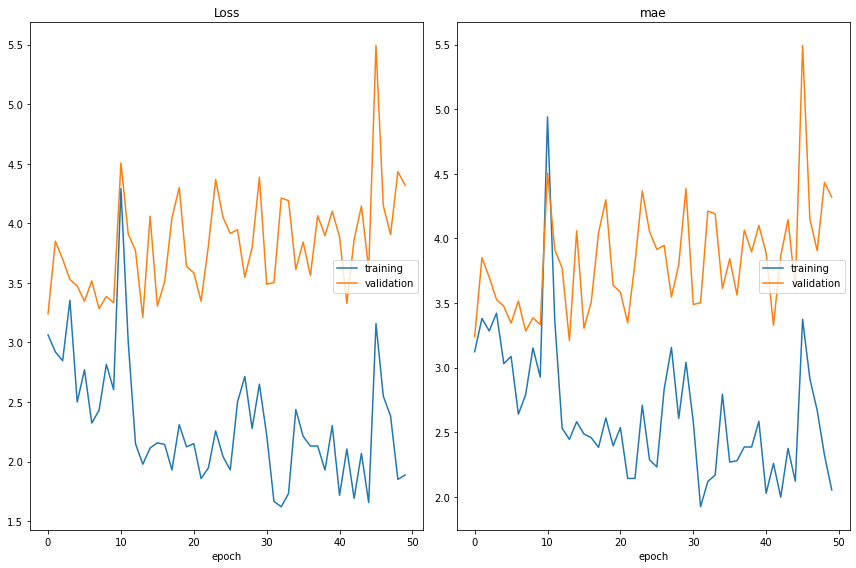

Loss
	training         	 (min:    1.620, max:    4.291, cur:    1.887)
	validation       	 (min:    3.210, max:    5.493, cur:    4.320)
mae
	training         	 (min:    1.924, max:    4.940, cur:    2.054)
	validation       	 (min:    3.210, max:    5.493, cur:    4.320)
1/1 [==============================] - 0s 87ms/step - loss: 6.5725 - mae: 6.5725
Val Score:  [6.57246208190918, 6.57246208190918]




"history = model.fit(\n    x_train,\n    y_train,\n    epochs=100,\n    batch_size=7,\n    validation_split=0.1,\n    class_weight=class_weight_dict,\n    callbacks=[PlotLossesCallback()]\n    #callbacks=[\n     #   tf.keras.callbacks.EarlyStopping(\n      #      monitor = 'val_loss',\n       #     patience=5,\n        #    restore_best_weights=True\n        #)\n    #]\n)"

In [31]:
inputs = tf.keras.Input(shape=(4007,1))
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.MaxPool1D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mae',
    metrics =  ['mae']
)

n_folds=3
epochs=50
batch_size=16

def fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size, model):
    results = model.fit(t_x, t_y, epochs=epochs, batch_size=batch_size, callbacks=[PlotLossesCallback()], 
              verbose=1, validation_split=0.1, class_weight=class_weight_dict)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size,model))
    print("======="*12, end="\n\n\n")

'''history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=7,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[PlotLossesCallback()]
    #callbacks=[
     #   tf.keras.callbacks.EarlyStopping(
      #      monitor = 'val_loss',
       #     patience=5,
        #    restore_best_weights=True
        #)
    #]
)'''

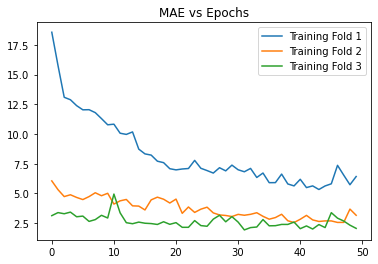

In [36]:
plt.title('MAE vs Epochs')
plt.plot(model_history[0].history['mae'], label='Training Fold 1')
plt.plot(model_history[1].history['mae'], label='Training Fold 2')
plt.plot(model_history[2].history['mae'], label='Training Fold 3')
plt.legend()
plt.show()

In [37]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 4007, 1)]         0         
                                                                 
 conv1d_17 (Conv1D)          (None, 4005, 64)          256       
                                                                 
 conv1d_18 (Conv1D)          (None, 4003, 64)          12352     
                                                                 
 dropout_16 (Dropout)        (None, 4003, 64)          0         
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 2001, 64)         0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 128064)            0         
                                                          

In [38]:
preds = model.predict(x_test)
preds = [int(age) for age in preds]
preds = le.inverse_transform(preds)
print(preds)

with open('test_submission.csv', 'w', encoding='UTF8', newline='') as f:
    count_id = 1
    writer = csv.writer(f)
    writer.writerow(['id','age'])
    for age in preds:
        line = [count_id, age]
        writer.writerow(line)
        count_id += 1

[24 20 19 22 22 25 54 28 51 62 58 65 63 66 18 19 21 28 20 25 42 57 51 68
 54 55 55 59]
